In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as mp
import matplotlib.ticker as mtick

pd.options.display.width = 500

In [2]:
# sensor: LoRaWAN, TI, Lansen
def getData(sensor):
    secondsPerMessage = 15 if sensor == 'TI' else 60
    
    
    # Daten importieren
    if sensor == 'LoRaWAN':
        data = pd.read_csv('../Messwerte/Reichweite/Test 2022-01-23 lorawan_log.csv', names=['time', 'received', 'frame', 'rssi', 'snr', 'raw'], sep=';')
    else: # Hier liegen die Daten von beiden Mioty-Sensoren:
        data = pd.read_csv('../Messwerte/Reichweite/Test 2022-01-23 mioty_log.csv', names=['time', 'sensor', 'frame', 'rssi', 'snr', 'raw'], sep=';')
    
        
        
    # Bei Mioty werden die Daten des ausgewählten Sensors gefiltert
    if sensor != 'LoRaWAN':
        data = data[data['sensor'] == sensor]
        data = data.reset_index(drop=True)

    data['time'] = pd.to_datetime(data['time'], utc=True)

    # Der TI-Client sendet die Nachricht immer in zwei Teilen im Abstand von ca. 4 Sekunden. Damit diese Teile jeweils als einzelne Nachrichten
    # betrachtet werden können, wird zur Uhrzeit des zweiten Teils der Nachricht 11 Sekunden aufaddiert. So ergibt sich im Idealfall ein Abstand
    # von 15 Sekunden zwischen den Nachrichten
    if sensor == 'TI':
        data.loc[data['frame'].str.startswith('02'), 'time'] = data['time'][data['frame'].str.startswith('02')] + pd.Timedelta(seconds=11)

    # Abstand zwischen den Nachrichten
    data['time_delta'] = data['time'].diff().dt.total_seconds()

    # Bei Mioty wurden nicht empfangene Daten nicht aufgezeichnet. Bei LoRaWAN wurde aufgezeichnet, wenn sie von einem anderen TTN-Gateway
    # empfangen wurden. Received wird dann auf False gesetzt
    if sensor == 'LoRaWAN':
        data['received'] = data['received'] == 'RECEIVED'
    else:
        data['received'] = True
        
        
        
    # Vom zeitliche Abstand jeder Nachricht wird der Soll-Abstand subtrahiert. Dadurch ergibt sich die Abweichung zum Soll.
    # Dann wird durch den Soll-Abstand dividiert und gerundet. So ergibt sich die Anzahl an Nachrichten, die jeweils zwischen zwei Nachrichten fehlen
    missingMessages = ((data['time_delta'][1:] - secondsPerMessage) / secondsPerMessage).round().astype(int)

    print(missingMessages.sum(), 'messages missing')

    # Diese Anzahl an Nachrichten wird dann erzeugt mit dem Attribut received auf False
    insertedMessages = pd.DataFrame(data=[], columns=['time', 'received', 'frame', 'snr', 'rssi', 'raw', 'time_delta'])
    for index, val in missingMessages.iloc[::-1].items():
        time = data['time'][index - 1]
        for x in range(val):
            time = time + pd.Timedelta(seconds=secondsPerMessage)
            insertedMessages = insertedMessages.append({
                'time': time,
                'received': False,
                'frame': None,
                'snr': np.nan,
                'rssi': np.nan,
                'raw': None,
                'time_delta': None
            }, ignore_index=True)

    # Neue Einträge hinzufügen und nach Uhrzeit sortieren
    newData = pd.concat([data, insertedMessages], ignore_index=True)
    newData = newData.sort_values('time', ignore_index=True)

    
    
    # Distanzdaten laden
    distances = pd.read_csv('../Messwerte/Reichweite/Test 2022-01-23 distance_info.csv', sep=';')
    
    
    
    distances['date_from'] = pd.to_datetime(distances['date_from'], utc=True)
    distances['date_to'] = pd.to_datetime(distances['date_to'], utc=True)

    # Hinzufügen der Distanz zu den Einträgen der Nachrichten anhand von der Uhrzeit
    dataDistances = []
    for row in newData['time']:
        distance = distances['distance'][(row >= distances['date_from']) & (row <= distances['date_to'])]
        if distance.size == 0: # Nachricht wurde nicht während einer Messung gesendet, sondern vor, nach oder zwischen den einzelnen Messungen
            dataDistances.append(None)
        else:
            dataDistances.append(distance.values[0])

    newData = newData.assign(distance=dataDistances)
    
    
    
    # Nur Nachrichten betrachten, die während den Messungen gesendet wurden
    relevantData = newData[np.invert(np.isnan(newData.distance))]
    
    # Durchschnittliche SNR und RRSI für jede Distanz berechnen
    dataPerDistance = relevantData.groupby('distance').mean()
    # Anzahl an gesendeten und empfangen Nachrichten, sowie die Erfolgsrate berechnen
    successRate = relevantData.groupby('distance').agg(receiveCount=('received', 'sum'), sendCount=('received', 'count'), successRate=('received', 'mean'))

    dataPerDistance = pd.concat([dataPerDistance, successRate], axis=1)
    
    if sensor == 'LoRaWAN':
        sensor = 'Milesight'
    
    # Signal-Rausch-Abstand Plot:
    ax = relevantData.plot(x='distance', y='snr', marker='.', linestyle='')
    ax.set_title('Signal-Rausch-Abstand ' + sensor)
    ax.set_xlabel('Distanz in m')
    ax.set_ylabel('Signal-Rausch-Abstand in dB')
    ax.get_legend().remove()
    
    ax.get_figure().savefig("snr-" + sensor + ".pdf", bbox_inches='tight')
    
    
    # Signalstärke Plot:
    ax = relevantData.plot(x='distance', y='rssi', marker='.', linestyle='')
    ax.set_title('Empfangene Signalstärke ' + sensor)
    ax.set_xlabel('Distanz in m')
    ax.set_ylabel('Signalstärke in dBm')
    ax.get_legend().remove()
    
    ax.get_figure().savefig("rssi-" + sensor + ".pdf", bbox_inches='tight')
    
    return dataPerDistance

4 messages missing
163 messages missing
33 messages missing


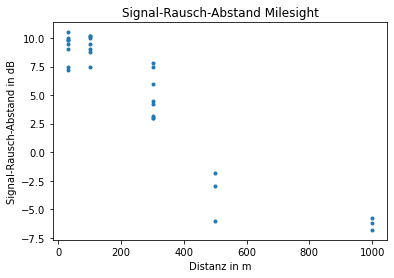

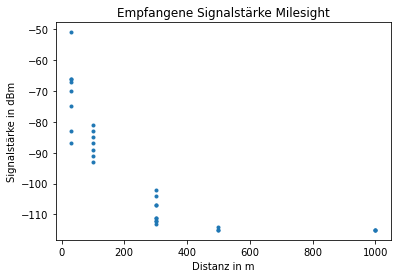

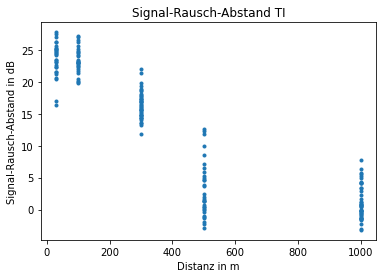

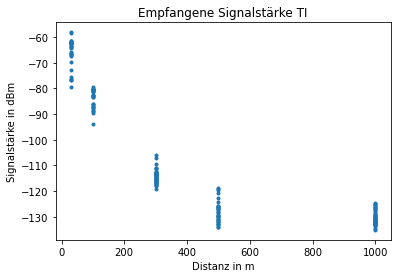

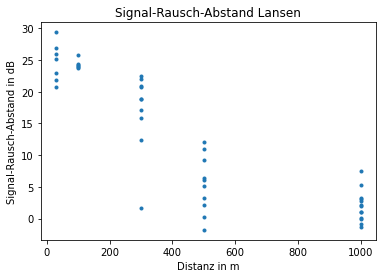

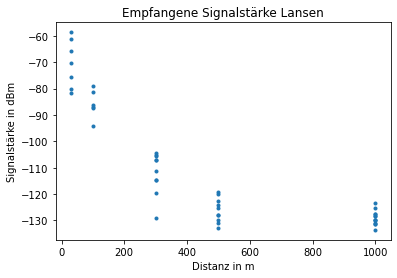

In [5]:
dataLoRaWAN = getData('LoRaWAN')
dataTI = getData('TI')
dataLansen = getData('Lansen')

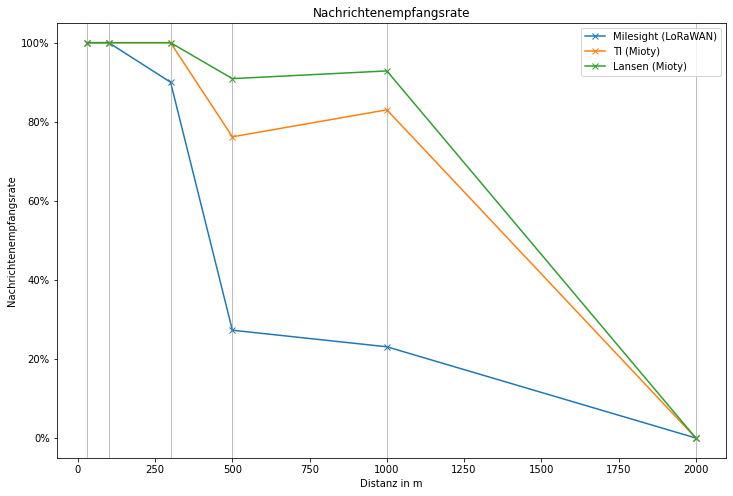

In [6]:
ax = dataLoRaWAN.plot(y='successRate', figsize=(12, 8), marker='x')
dataTI.plot(y='successRate', ax=ax, marker='x')
dataLansen.plot(y='successRate', ax=ax, marker='x')

mp.axvline(30, color='grey', lw=0.5)
mp.axvline(100, color='grey', lw=0.5)
mp.axvline(300, color='grey', lw=0.5)
mp.axvline(500, color='grey', lw=0.5)
mp.axvline(1000, color='grey', lw=0.5)
mp.axvline(2000, color='grey', lw=0.5)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('Nachrichtenempfangsrate')
ax.set_xlabel('Distanz in m')
ax.set_ylabel('Nachrichtenempfangsrate')
mp.legend(['Milesight (LoRaWAN)', 'TI (Mioty)', 'Lansen (Mioty)']);
ax.get_figure().savefig("empfangsrate.pdf", bbox_inches='tight')

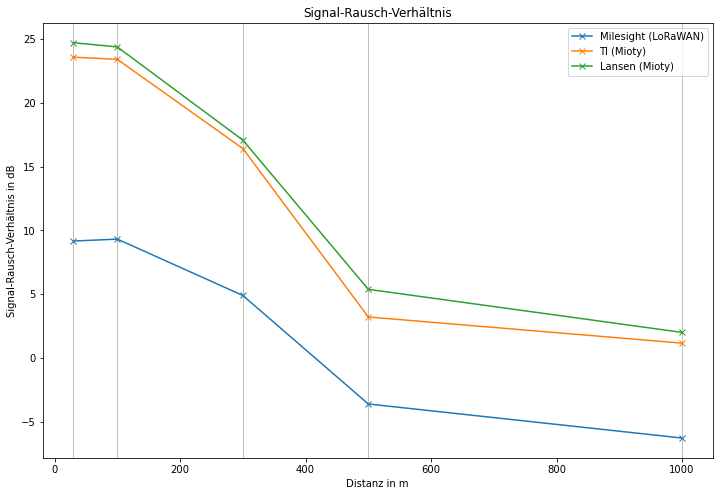

In [7]:
ax = dataLoRaWAN.plot(y='snr', figsize=(12, 8), marker='x')
dataTI.plot(y='snr', ax=ax, marker='x')
dataLansen.plot(y='snr', ax=ax, marker='x')

mp.axvline(30, color='grey', lw=0.5)
mp.axvline(100, color='grey', lw=0.5)
mp.axvline(300, color='grey', lw=0.5)
mp.axvline(500, color='grey', lw=0.5)
mp.axvline(1000, color='grey', lw=0.5)

ax.set_title('Signal-Rausch-Verhältnis')
ax.set_xlabel('Distanz in m')
ax.set_ylabel('Signal-Rausch-Verhältnis in dB')
mp.legend(['Milesight (LoRaWAN)', 'TI (Mioty)', 'Lansen (Mioty)']);
ax.get_figure().savefig("snr.pdf", bbox_inches='tight')

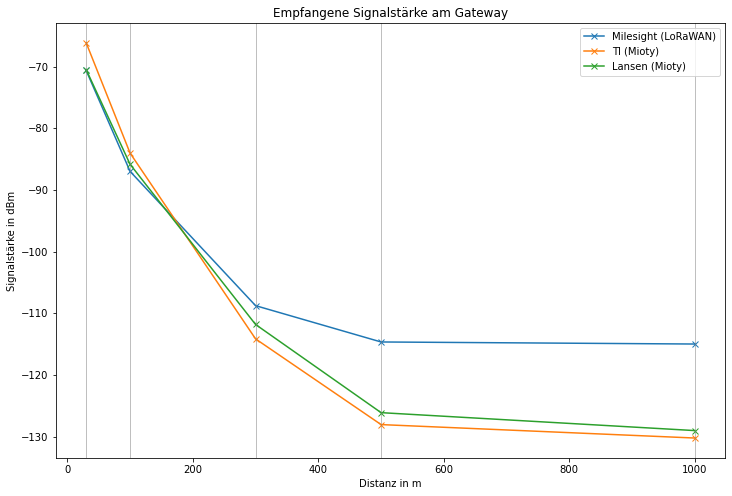

In [8]:
ax = dataLoRaWAN.plot(y='rssi', figsize=(12, 8), marker='x')
dataTI.plot(y='rssi', ax=ax, marker='x')
dataLansen.plot(y='rssi', ax=ax, marker='x')

mp.axvline(30, color='grey', lw=0.5)
mp.axvline(100, color='grey', lw=0.5)
mp.axvline(300, color='grey', lw=0.5)
mp.axvline(500, color='grey', lw=0.5)
mp.axvline(1000, color='grey', lw=0.5)

ax.set_title('Empfangene Signalstärke am Gateway')
ax.set_xlabel('Distanz in m')
ax.set_ylabel('Signalstärke in dBm')
mp.legend(['Milesight (LoRaWAN)', 'TI (Mioty)', 'Lansen (Mioty)']);
ax.get_figure().savefig("rssi.pdf", bbox_inches='tight')

In [9]:
print('Milesight:')
display(dataLoRaWAN)
print()
print('TI:')
display(dataTI)
print()
print('Lansen:')
display(dataLansen)

Milesight:


,rssi,snr,time_delta,receiveCount,sendCount,successRate
distance,,,,,,
30.0,-70.625000,9.162500,59.998797,8,8,1.000000
100.0,-87.000000,9.314286,59.992730,7,7,1.000000
300.0,-108.777778,4.900000,66.664343,9,10,0.900000
500.0,-114.666667,-3.600000,65.995759,3,11,0.272727
1000.0,-115.000000,-6.266667,59.999460,3,13,0.230769
2000.0,NaN,NaN,59.998183,0,19,0.000000



TI:


,rssi,snr,time_delta,receiveCount,sendCount,successRate
distance,,,,,,
30.0,-66.131034,23.565517,15.000000,29,29,1.000000
100.0,-84.035714,23.396429,13.928571,28,28,1.000000
300.0,-114.165854,16.409756,15.000000,41,41,1.000000
500.0,-128.065625,3.215625,19.687500,32,42,0.761905
1000.0,-130.245455,1.165909,18.409091,44,53,0.830189
2000.0,NaN,NaN,NaN,0,74,0.000000



Lansen:


,rssi,snr,time_delta,receiveCount,sendCount,successRate
distance,,,,,,
30.0,-70.485714,24.700000,60.714286,7,7,1.000000
100.0,-85.850000,24.366667,60.666667,6,6,1.000000
300.0,-111.830000,17.070000,60.800000,10,10,1.000000
500.0,-126.130000,5.380000,66.800000,10,11,0.909091
1000.0,-129.038462,2.007692,65.384615,13,14,0.928571
2000.0,NaN,NaN,NaN,0,18,0.000000


In [10]:
# Stärke des Rauschens:
print(dataLoRaWAN['rssi'] - dataLoRaWAN['snr'])
print(dataTI['rssi'] - dataTI['snr'])
print(dataLansen['rssi'] - dataLansen['snr'])

distance
30.0      -79.787500
100.0     -96.314286
300.0    -113.677778
500.0    -111.066667
1000.0   -108.733333
2000.0           NaN
dtype: float64
distance
30.0      -89.696552
100.0    -107.432143
300.0    -130.575610
500.0    -131.281250
1000.0   -131.411364
2000.0           NaN
dtype: float64
distance
30.0      -95.185714
100.0    -110.216667
300.0    -128.900000
500.0    -131.510000
1000.0   -131.046154
2000.0           NaN
dtype: float64
